In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif",
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    'figure.dpi': 125
})

In [3]:
sig_df = pd.read_csv('data/Jewel.csv')
bg_df = pd.read_csv('data/Pythia.csv')
herwig_df = pd.read_csv('data/Herwig.csv')
hydrocolbt_df = pd.read_csv('data/CoLBTHydro.csv')

In [4]:
sig_X = sig_df.dropna().iloc[:,0:-1].values
sig_Y = sig_df.dropna().iloc[:,-1].values

bg_X = bg_df.dropna().iloc[:,0:-1].values
bg_Y = bg_df.dropna().iloc[:,-1].values

herwig_X = herwig_df.dropna().iloc[:,0:-1].values
herwig_Y = herwig_df.dropna().iloc[:,-1].values

hydrocolbt_X = hydrocolbt_df.dropna().iloc[:,0:-1].values
hydrocolbt_Y = hydrocolbt_df.dropna().iloc[:,-1].values

In [5]:
sig_X_train, sig_X_test, sig_Y_train, sig_Y_test = train_test_split(sig_X, sig_Y, train_size=0.9, shuffle=False)
bg_X_train, bg_X_test, bg_Y_train, bg_Y_test = train_test_split(bg_X, bg_Y, train_size=0.9, shuffle=False)
herwig_X_train, herwig_X_test, herwig_Y_train, herwig_Y_test = train_test_split(herwig_X, herwig_Y, train_size=0.9, shuffle=False)
hydrocolbt_X_train, hydrocolbt_X_test, hydrocolbt_Y_train, hydrocolbt_Y_test = train_test_split(hydrocolbt_X, hydrocolbt_Y, train_size=0.9, shuffle=False)

In [6]:
X_test = np.concatenate((sig_X_test, bg_X_test, herwig_X_test, hydrocolbt_X_test), axis=0)
Y_test = np.concatenate((sig_Y_test, bg_Y_test, herwig_Y_test, hydrocolbt_Y_test), axis=0)

In [9]:
model = TabNetRegressor()
model.load_model('model/model.zip')

In [10]:
Y_pred = model.predict(X_test)

In [11]:
explain_matrixq, masksq = model.explain(sig_X_test)
explain_matrixu, masksu = model.explain(bg_X_test)

In [12]:
def explain(i):
    exp_matrix = explain_matrix[i]/explain_matrix[i].sum()
    exp = []
    for i in range(len(exp_matrix)):
        if exp_matrix[i]: exp.append(f"{features[i]}: {exp_matrix[i]}")
    return exp

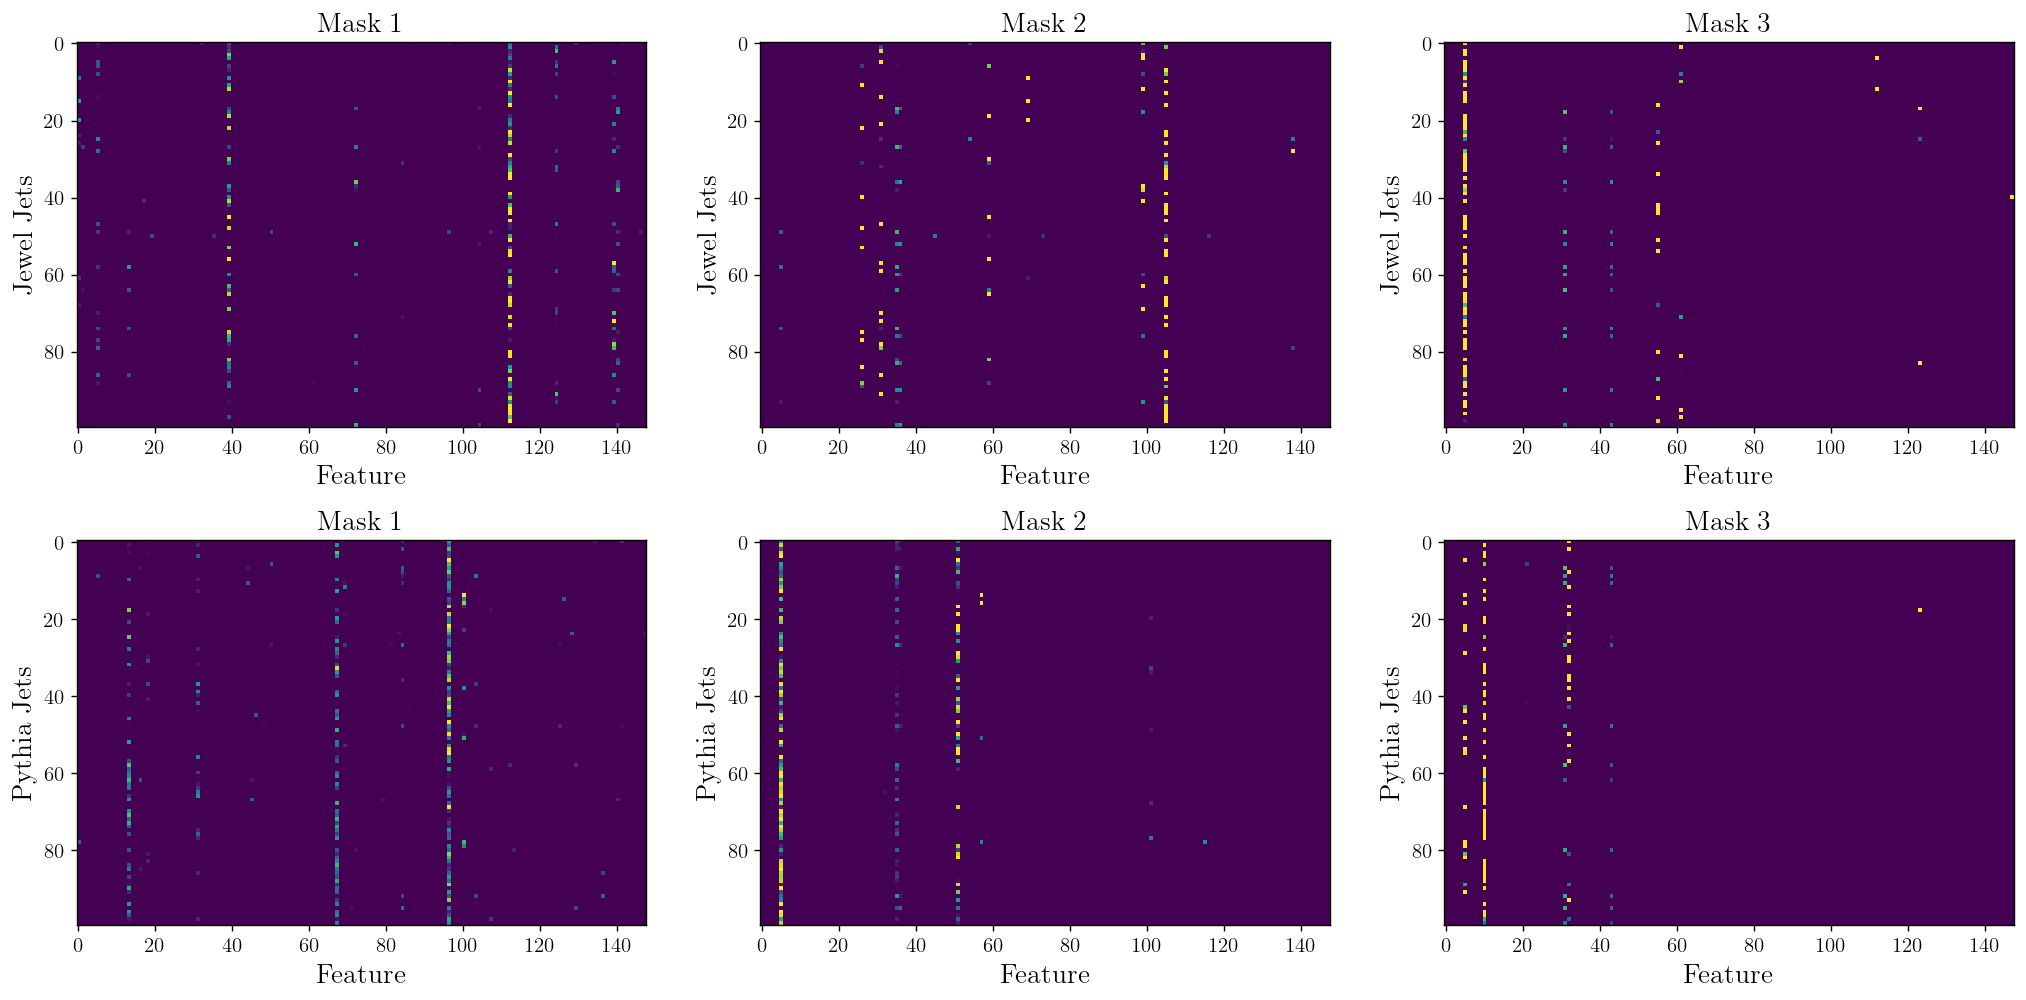

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(20,9.5))
for i in range(3):
    axs[0][i].imshow(masksq[i][:100])
    axs[0][i].set_title(f"Mask {i+1}", fontsize=16)
    axs[0][i].set_xlabel(f"Feature", fontsize=16)
    axs[0][i].set_ylabel(f"Jewel Jets", fontsize=16)
for i in range(3):
    axs[1][i].imshow(masksu[i][0:100])
    axs[1][i].set_title(f"Mask {i+1}", fontsize=16)
    axs[1][i].set_xlabel(f"Feature", fontsize=16)
    axs[1][i].set_ylabel(f"Pythia Jets", fontsize=16)
plt.savefig("featuremasks.pdf", bbox_inches='tight')

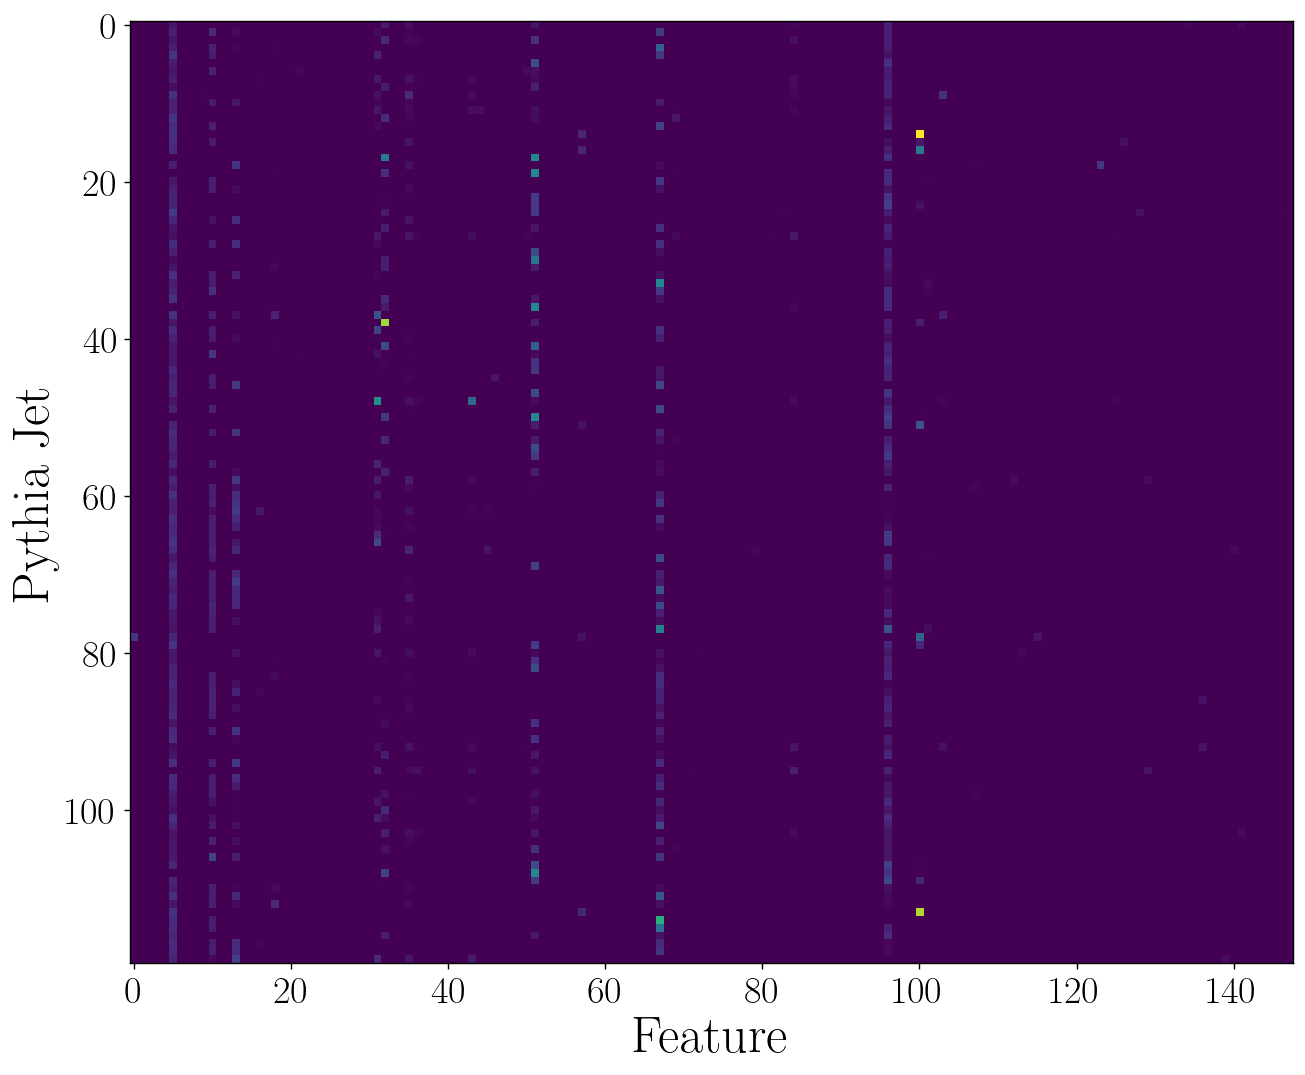

In [14]:
fig, ax = plt.subplots(1, figsize=(12,11))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.imshow(explain_matrixu[0:120])
ax.set_xlabel(f"Feature", fontsize=30)
ax.set_ylabel(f"Pythia Jet", fontsize=30)
plt.savefig("explainmatrixpythia.pdf", bbox_inches='tight')
plt.show()

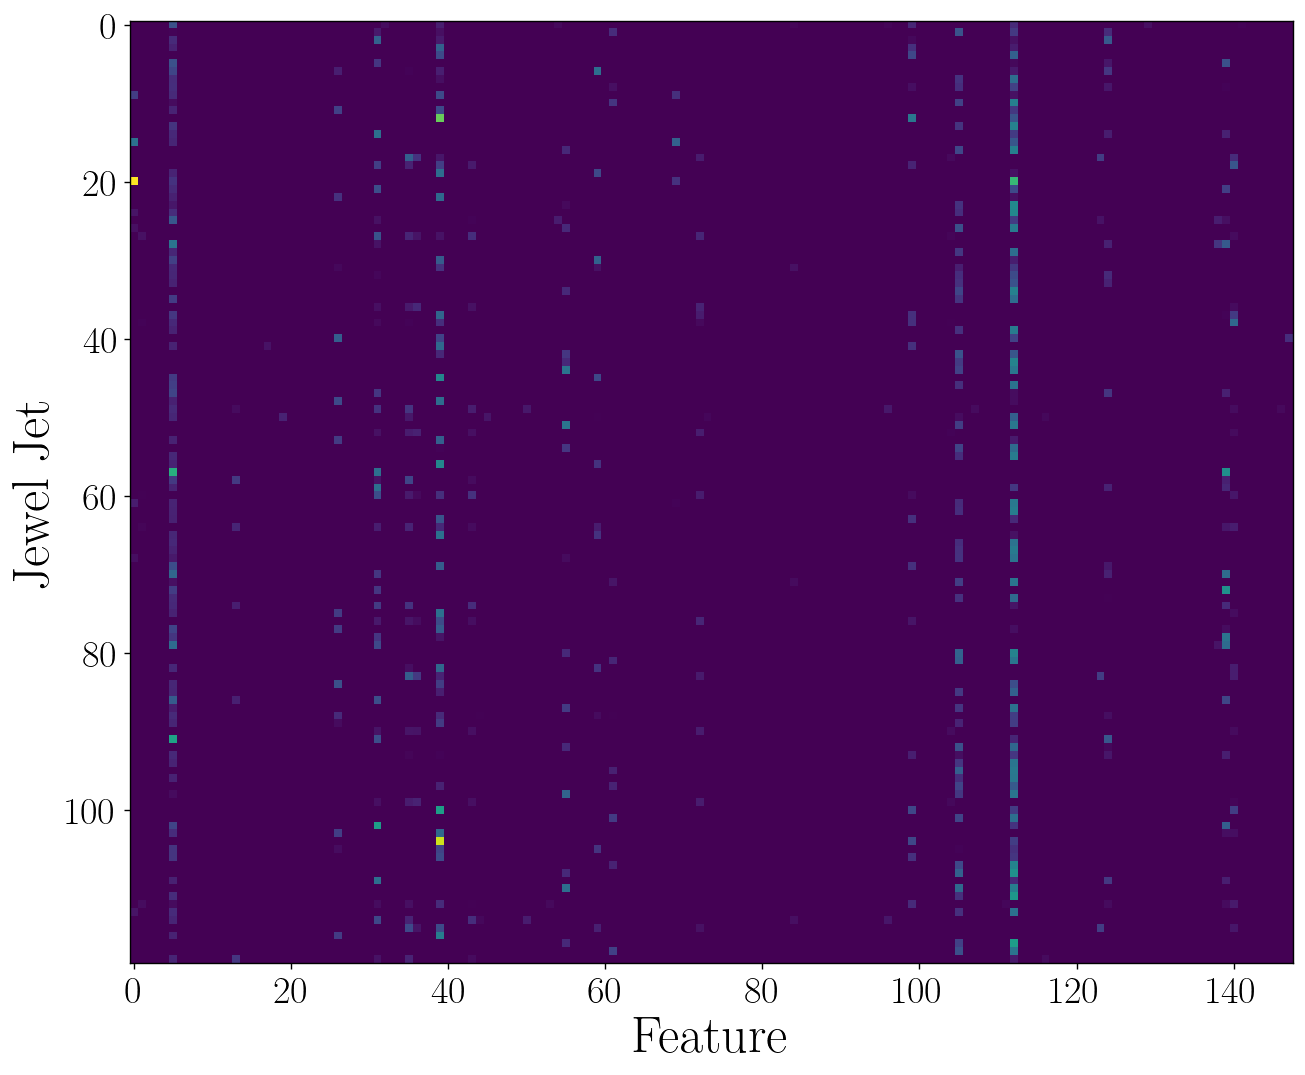

In [15]:
fig, ax = plt.subplots(1, figsize=(12,11))
ax.imshow(explain_matrixq[0:120])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_xlabel(f"Feature", fontsize=30)
ax.set_ylabel(f"Jewel Jet", fontsize=30)
plt.savefig("explainmatrixjewel.pdf", bbox_inches='tight')
plt.show()

In [16]:
SIG_out = model.predict(sig_X_test)
BG_out = model.predict(bg_X_test)
herwig_out = model.predict(herwig_X_test)
hydrocolbt_out = model.predict(hydrocolbt_X_test)

In [17]:
jewellowquench = np.where(SIG_out < 0.4)
jewelhighquench = np.where(SIG_out > 0.8)

In [18]:
jewel_low_quench_jetm = []
for i in jewellowquench[0]:
  jewel_low_quench_jetm.append(sig_X_test[i][1])
jewel_low_quench_jetm = np.array(jewel_low_quench_jetm)
jewel_low_quench_jetm = jewel_low_quench_jetm[jewel_low_quench_jetm != 0]

In [19]:
jewel_high_quench_jetm = []
for i in jewelhighquench[0]:
  jewel_high_quench_jetm.append(sig_X_test[i][1])
jewel_high_quench_jetm = np.array(jewel_high_quench_jetm)
jewel_high_quench_jetm = jewel_high_quench_jetm[jewel_high_quench_jetm != 0]

In [20]:
bins = np.linspace(0, 100, 25)

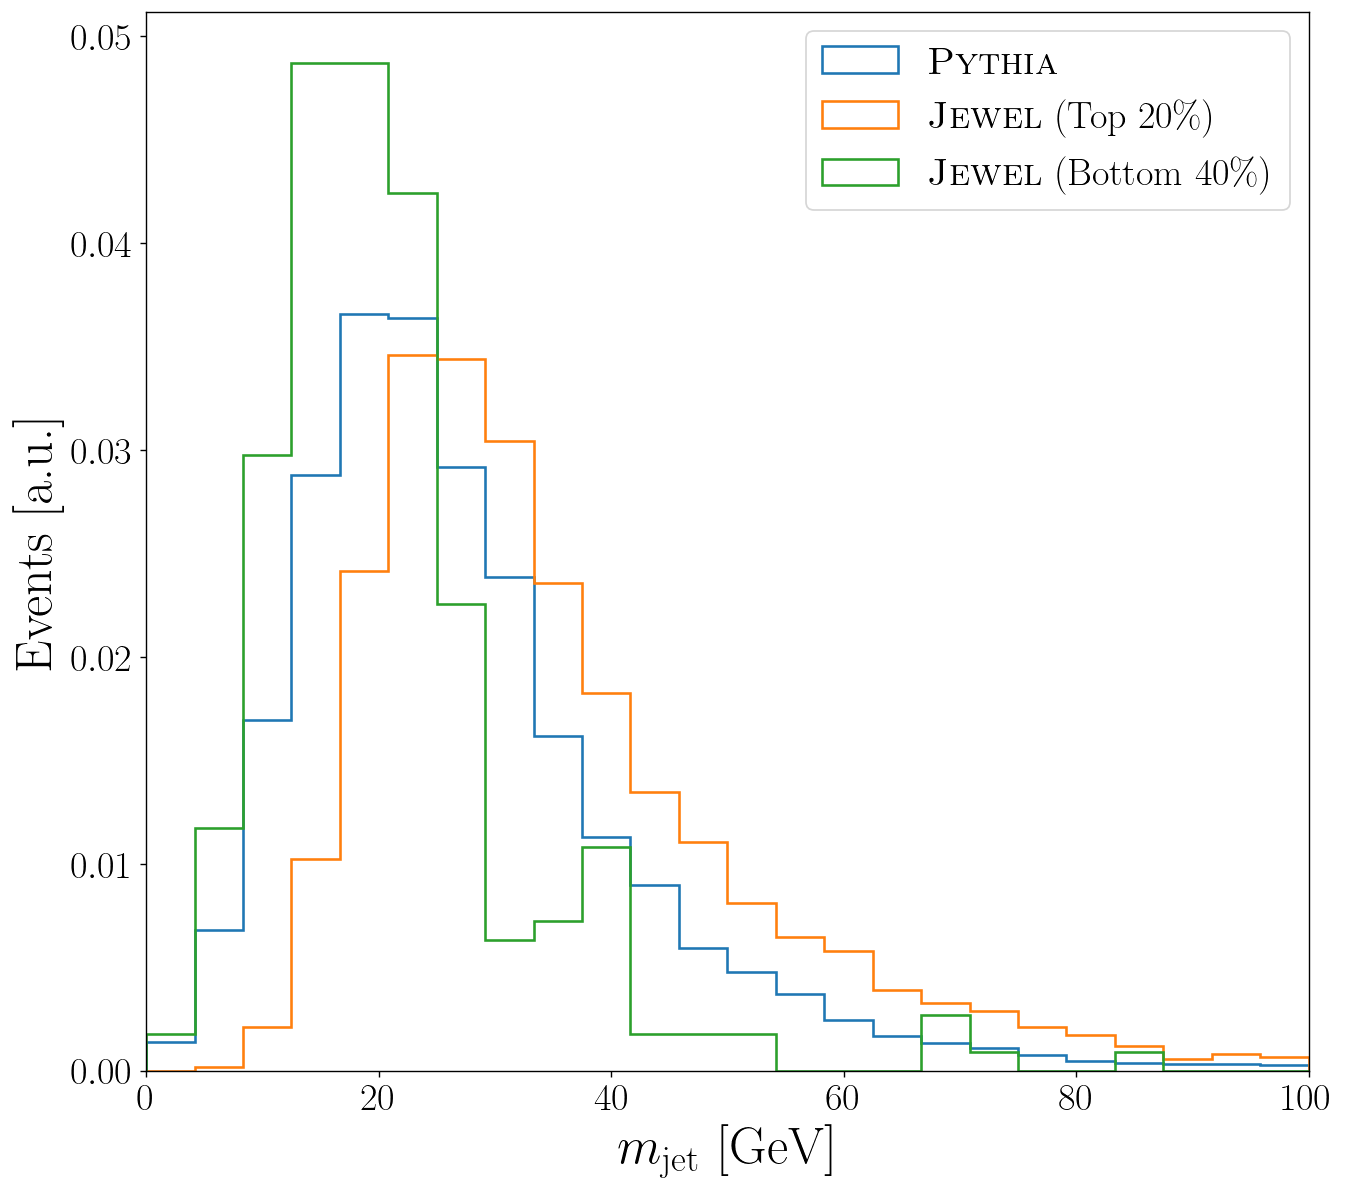

In [21]:
fig, ax = plt.subplots(1, figsize=(12,11))
plt.hist(bg_X_test[:,1], bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Pythia}")
plt.hist(jewel_high_quench_jetm, bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel} (Top 20\%)")
plt.hist(jewel_low_quench_jetm, bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel} (Bottom 40\%)")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_xlabel("$m_{\mathrm{jet}}$ [GeV]", fontsize=30)
# ax.set_ylabel(r"$\frac{1}{N}\frac{\mathrm{d}N}{\mathrm{d}{m}_{\mathrm{jet}}}$", fontsize=30)
ax.set_ylabel(r"Events [a.u.]", fontsize=30)
plt.legend(loc='upper right', fontsize=22)
plt.xlim(0,100)
plt.savefig('jetmassdistjewel.pdf', bbox_inches='tight')
plt.show()

In [22]:
jewel_low_quench_mult = []
for i in jewellowquench[0]:
  jewel_low_quench_mult.append(sig_X_test[i][0])
jewel_low_quench_mult = np.array(jewel_low_quench_mult)

In [23]:
jewel_high_quench_mult = []
for i in jewelhighquench[0]:
  jewel_high_quench_mult.append(sig_X_test[i][0])
jewel_high_quench_mult = np.array(jewel_high_quench_mult)

In [24]:
bins = np.linspace(0, 200, 25)

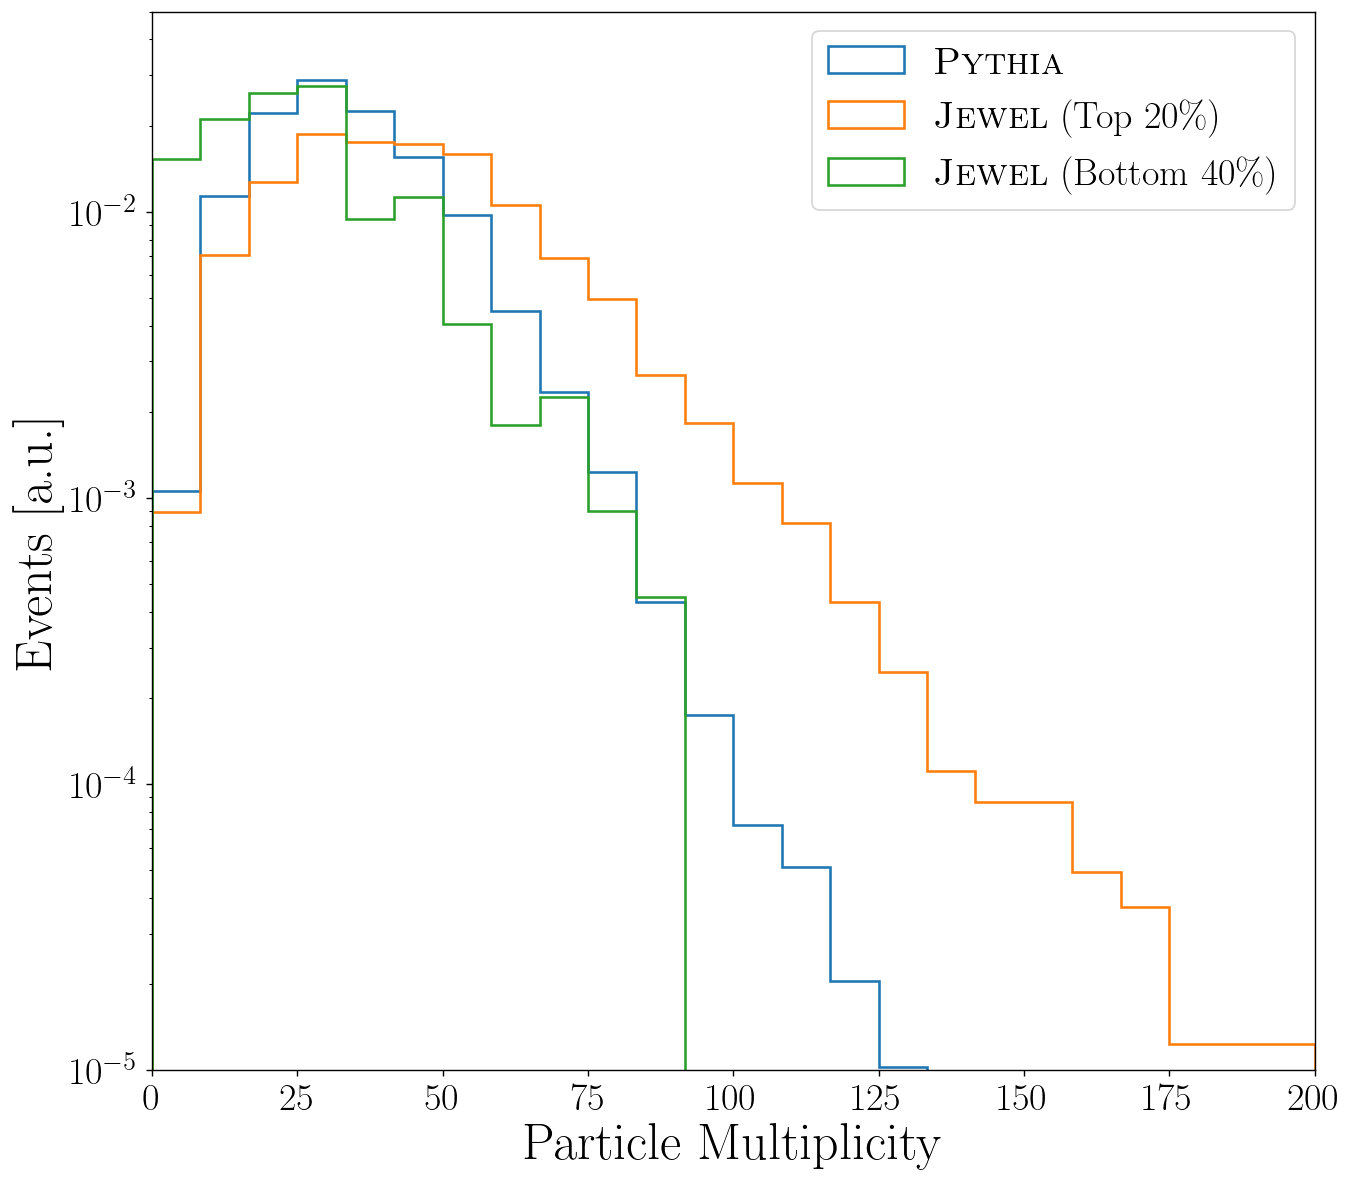

In [25]:
fig, ax = plt.subplots(1, figsize=(12,11))
plt.hist(bg_X_test[:,0], bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Pythia}")
plt.hist(jewel_high_quench_mult, bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel}  (Top 20\%)")
plt.hist(jewel_low_quench_mult, bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel}  (Bottom 40\%)")
ax.set_xlabel("Particle Multiplicity", fontsize=30)
ax.set_ylabel(r"Events [a.u.]", fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc='upper right', fontsize=22)
plt.xlim(0, 200)
plt.ylim(1e-5, 0.05)
plt.yscale('log')
plt.savefig('jetmultdistjewel.pdf', bbox_inches='tight')
plt.show()

In [26]:
jewel_low_quench_zg = []
for i in jewellowquench[0]:
  jewel_low_quench_zg.append(sig_X_test[i][4])
jewel_low_quench_zg = np.array(jewel_low_quench_zg)

In [27]:
jewel_high_quench_zg = []
for i in jewelhighquench[0]:
  jewel_high_quench_zg.append(sig_X_test[i][4])
jewel_high_quench_zg = np.array(jewel_high_quench_zg)

In [28]:
bins = np.linspace(0, 0.5,12)

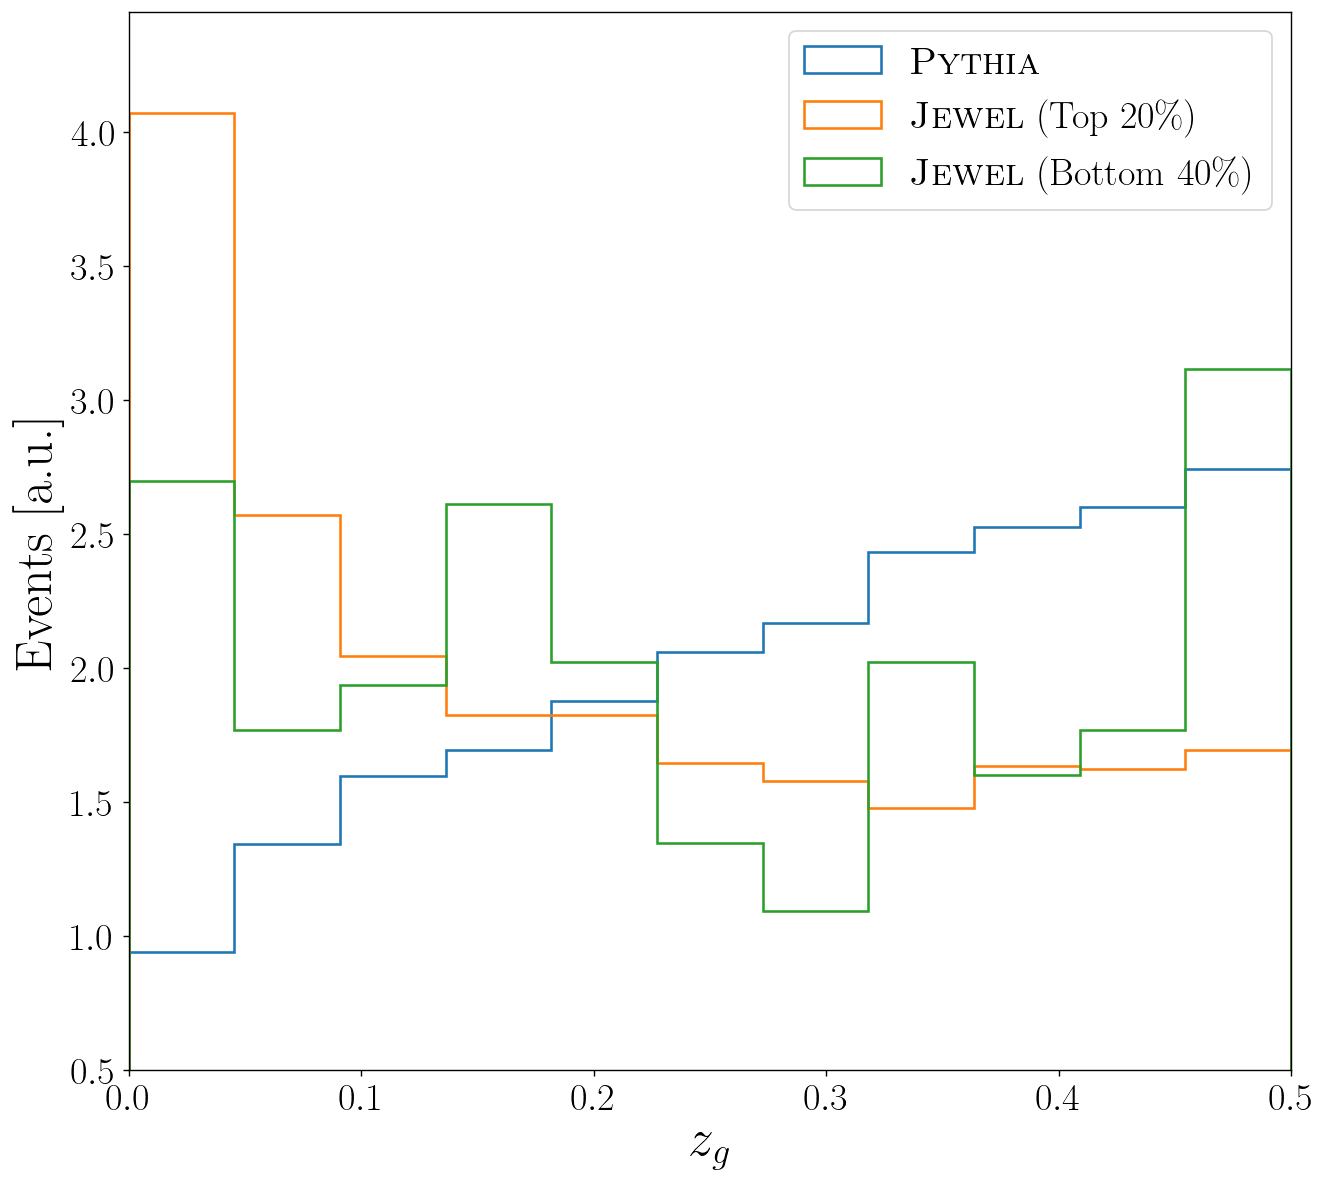

In [29]:
fig, ax = plt.subplots(1, figsize=(12,11))
plt.hist(bg_X_test[:,4][bg_X_test[:,4] != 0], bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Pythia}")
plt.hist(jewel_high_quench_zg[jewel_high_quench_zg != 0], bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel}  (Top 20\%)")
plt.hist(jewel_low_quench_zg[jewel_low_quench_zg != 0], bins, density=True, fill=False, histtype='step', linewidth=1.5, label="\\textsc{Jewel}  (Bottom 40\%)")
ax.set_xlabel("$z_g$", fontsize=30)
ax.set_ylabel(r"Events [a.u.]", fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc='upper right', fontsize=22)
plt.xlim(0, 0.5)
plt.ylim(0.5, 4.45)
# plt.yscale('log')
plt.savefig('jetzgdistjewel.pdf', bbox_inches='tight')
plt.show()